In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import time

from datasets import dataset_utils

# Main slim library
from tensorflow.contrib import slim

In [2]:
import tensorflow as tf
from datasets import dataset_utils

url = "http://download.tensorflow.org/data/flowers.tar.gz"
flowers_data_dir = 'dataset_photos'

if not tf.gfile.Exists(flowers_data_dir):
    tf.gfile.MakeDirs(flowers_data_dir)
    
else:
    print('Folder already exists')

# dataset_utils.download_and_uncompress_tarball(url, flowers_data_dir)

Folder already exists


In [3]:
! ls dataset_photos/

flowers.tar.gz
flowers_train_00000-of-00005.tfrecord
flowers_train_00001-of-00005.tfrecord
flowers_train_00002-of-00005.tfrecord
flowers_train_00003-of-00005.tfrecord
flowers_train_00004-of-00005.tfrecord
flowers_validation_00000-of-00005.tfrecord
flowers_validation_00001-of-00005.tfrecord
flowers_validation_00002-of-00005.tfrecord
flowers_validation_00003-of-00005.tfrecord
flowers_validation_00004-of-00005.tfrecord
labels.txt
LICENSE.txt


### Display some of the data.

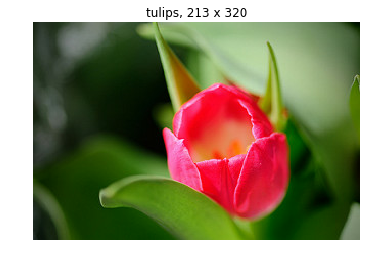

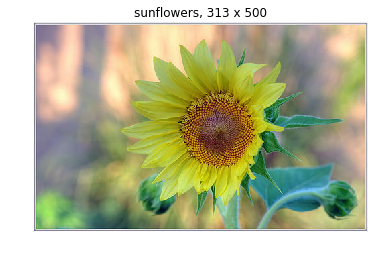

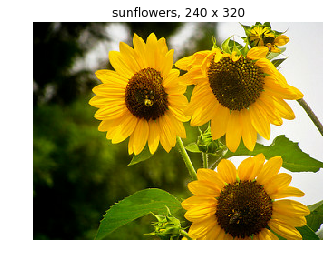

In [4]:
from datasets import flowers
import tensorflow as tf

from tensorflow.contrib import slim

with tf.Graph().as_default(): 
    dataset = flowers.get_split('train', flowers_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(4):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

In [5]:
from preprocessing import inception_preprocessing
import tensorflow as tf

from tensorflow.contrib import slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

In [31]:
!ls -ltr models/v1_4_lr01

total 1580680
-rw-rw-r-- 1 admini admini    369542 Aug 31 11:29 graph.pbtxt
-rw-rw-r-- 1 admini admini      1033 Aug 31 11:29 model.ckpt-0.index
-rw-rw-r-- 1 admini admini 808770892 Aug 31 11:29 model.ckpt-0.data-00000-of-00001
-rw-rw-r-- 1 admini admini    177914 Aug 31 11:29 model.ckpt-0.meta
-rw-rw-r-- 1 admini admini      1033 Aug 31 11:31 model.ckpt-4.index
-rw-rw-r-- 1 admini admini 808770892 Aug 31 11:31 model.ckpt-4.data-00000-of-00001
-rw-rw-r-- 1 admini admini       124 Aug 31 11:31 checkpoint
-rw-rw-r-- 1 admini admini    177914 Aug 31 11:31 model.ckpt-4.meta
-rw-rw-r-- 1 admini admini    322397 Aug 31 11:31 events.out.tfevents.1535695191.mait


### Download the Inception V1 checkpoint




In [14]:
from datasets import dataset_utils

url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = 'inception_checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

# dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)


### Apply Pre-trained Inception V1 model to Images.

We have to convert each image to the size expected by the model checkpoint.
There is no easy way to determine this size from the checkpoint itself.
So we use a preprocessor to enforce this.

In [7]:
! ls inception_checkpoints/

inception_v1_2016_08_28.tar.gz	inception_v1.ckpt


INFO:tensorflow:Restoring parameters from inception_checkpoints/inception_v1.ckpt


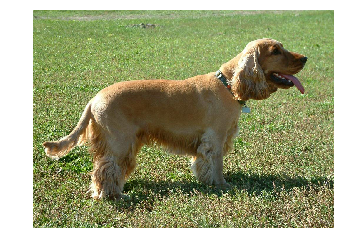

Probability 45.14% => [cocker spaniel, English cocker spaniel, cocker]
Probability 21.55% => [Sussex spaniel]
Probability 10.37% => [Irish setter, red setter]
Probability 5.06% => [Welsh springer spaniel]
Probability 2.99% => [clumber, clumber spaniel]


In [22]:
import numpy as np
import os
import tensorflow as tf

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

from datasets import imagenet
from nets import inception
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim

image_size = inception.inception_v1.default_image_size

with tf.Graph().as_default():
    url = 'https://upload.wikimedia.org/wikipedia/commons/7/70/EnglishCockerSpaniel_simon.jpg'
    image_string = urllib.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(processed_images, num_classes=1001, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
        slim.get_model_variables('InceptionV1'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index]))

### Fine-tune the model on a different set of labels.

We will fine tune the inception model on the Flowers dataset.

In [17]:
# Note that this may take several minutes.

import os

from datasets import flowers
from nets import inception
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim
image_size = inception.inception_v1.default_image_size

NO_OF_STEPS = 50
LEARNING_RATE = 0.01

def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV1/Logits", "InceptionV1/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                print('Exclusion ', exclusion)
                break
        else:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v1.ckpt'), variables_to_restore, ignore_missing_vars=True)

In [24]:
global inc 
inc = 0

In [26]:
train_dir = 'models/v1_lr{}_{}_counter{}'.format(LEARNING_RATE, NO_OF_STEPS, inc)
inc = inc + 1

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    images, _, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total_Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=NO_OF_STEPS)
        
  
print('Finished training. Last batch loss %f' % final_loss)

Exclusion  InceptionV1/Logits
Exclusion  InceptionV1/Logits
INFO:tensorflow:Restoring parameters from inception_checkpoints/inception_v1.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path models/v1_lr0.01_50_counter1/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Recording summary at step 0.
INFO:tensorflow:global step 1: loss = 1.9206 (8.080 sec/step)
INFO:tensorflow:global step 2: loss = 3.6860 (4.436 sec/step)
INFO:tensorflow:global step 3: loss = 3.9090 (4.451 sec/step)
INFO:tensorflow:global step 4: loss = 2.6342 (4.781 sec/step)
INFO:tensorflow:global step 5: loss = 3.9966 (4.375 sec/step)
INFO:tensorflow:global step 6: loss = 2.5453 (4.409 sec/step)
INFO:tensorflow:global step 7: loss = 2.6160 (4.299 sec/step)
INFO:tensorflow:global step 8: loss = 2.1692 (4.297 sec/step)
INFO:tensorflow:global step 9: loss = 1.7753 (4.30

KeyboardInterrupt: 

In [79]:
! python3.6 eval_image_classifier.py \
  --checkpoint_path='models/v1_lr0.01' \
  --eval_dir=models/v1_lr0.01_steps5_eval \
  --dataset_name=flowers \
  --dataset_split_name=validation \
  --dataset_dir=dataset_photos \
  --model_name=inception_v1

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
Instructions for updating:
Please switch to tf.metrics.mean
INFO:tensorflow:Evaluating models/v1_lr0.01/model.ckpt-20
INFO:tensorflow:Starting evaluation at 2018-08-31-09:14:49
INFO:tensorflow:Graph was finalized.
2018-08-31 14:44:50.196574: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
INFO:tensorflow:Restoring parameters from models/v1_lr0.01/model.ckpt-20
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
2018-08-31 14:44:51.232706: W tensorflow/core/framework/a

In [63]:
! ls

BUILD				models
dataset_photos			nets
datasets			preprocessing
deployment			README.md
download_and_convert_data.py	scripts
eval_image_classifier.py	setup.py
export_inference_graph.py	slim_walkthrough-Copy1.ipynb
export_inference_graph_test.py	slim_walkthrough.ipynb
flower_photos			train_image_classifier.py
inception_checkpoints		trial
__init__.py			WORKSPACE
model_pruning


In [62]:
! pip list | grep tensorflow

tensorflow                    1.10.1                


### Apply fine tuned model to some images.

INFO:tensorflow:Restoring parameters from models/v1_lr0.01_steps2/model.ckpt-3


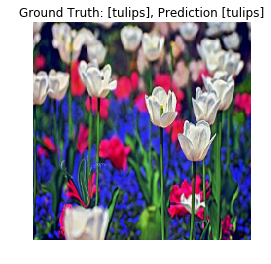

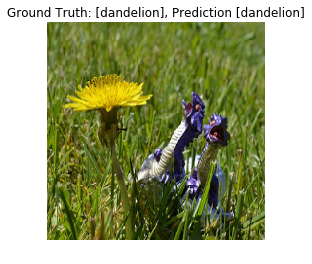

In [45]:
import numpy as np
import tensorflow as tf
from datasets import flowers
from nets import inception

from tensorflow.contrib import slim

image_size = inception.inception_v1.default_image_size
batch_size = 3

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
            
    
            # Define the metrics:
            names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
                'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
                'eval/Recall@5': slim.metrics.streaming_recall_at_k(logits, labels, 5),
            })

            print('Running evaluation Loop...')
            checkpoint_path = tf.train.latest_checkpoint(train_dir)
            metric_values = slim.evaluation.evaluate_once(
                master='',
                checkpoint_path=checkpoint_path,
                logdir=train_dir,
                eval_op=list(names_to_updates.values()),
                final_op=list(names_to_values.values()))

            names_to_values = dict(zip(names_to_values.keys(), metric_values))
            for name in names_to_values:
                print('%s: %f' % (name, names_to_values[name]))

#             for i in range(batch_size): 
#                 image = np_images_raw[i, :, :, :]
#                 true_label = np_labels[i]
#                 predicted_label = np.argmax(np_probabilities[i, :])
#                 predicted_name = dataset.labels_to_names[predicted_label]
#                 true_name = dataset.labels_to_names[true_label]
                
#                 plt.figure()
#                 plt.imshow(image.astype(np.uint8))
#                 plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
#                 plt.axis('off')
#                 plt.show()

In [55]:
from datasets import flowers

image_size = inception.inception_v1.default_image_size
batch_size = 3

# This might take a few minutes.
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    images, _, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=False)
    predictions = tf.argmax(logits, 1)
    
    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/Recall@5': slim.metrics.streaming_recall_at_k(logits, labels, 5),
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        eval_op=list(names_to_updates.values()),
        final_op=list(names_to_values.values()))

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))

Running evaluation Loop...
INFO:tensorflow:Starting evaluation at 2018-08-31-08:50:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/v1_lr0.01_steps2/model.ckpt-3
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-08-31-08:50:48
eval/Accuracy: 0.312500
eval/Recall@5: 1.000000


In [39]:
import numpy as np
import os
import tensorflow as tf

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

from datasets import imagenet
from nets import inception
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim

image_size = inception.inception_v1.default_image_size

with tf.Graph().as_default():
    url = 'https://upload.wikimedia.org/wikipedia/commons/7/70/EnglishCockerSpaniel_simon.jpg'
    image_string = urllib.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(processed_images, num_classes=1001, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
        slim.get_model_variables('InceptionV1'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index]))

Will save model to models/v1_epoch4_lr01


NameError: name 'my_cnn' is not defined